In [69]:
import os
import logging
from os import listdir
from os.path import isfile, join
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cooler
import cooltools.lib.plotting
from cooltools import insulation
import cooltools
import seaborn as sns
from packaging import version
import collections
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import bioframe
from pybedtools import BedTool as pbt
import bbi
from tqdm import tqdm
from adjustText import adjust_text
from os.path import basename
from scipy.spatial.distance import pdist, squareform
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import plotly.express as px
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import fclusterdata
from sklearn.cluster import DBSCAN
import gseapy as gp
from gseapy import barplot, dotplot
import bioframe as bf
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import fdrcorrection
from dotenv import load_dotenv
assert os.environ['CONDA_DEFAULT_ENV'] == "cultures_hic"

In [14]:
import matplotlib as mpl

mpl.rcParams['font.family'] = 'Helvetica'
mpl.rc('lines', linewidth=0.4)
mpl.rc('font', family='Helvetica', size=8)
mpl.rc('axes', labelsize=8, titlesize=8, linewidth=0.4)
mpl.rc('legend', fontsize=8)
mpl.rc('xtick', labelsize=6)
mpl.rc('xtick.major', width=0.4, size=2)
mpl.rc('xtick.minor', width=0.4, size=1)
mpl.rc('ytick', labelsize=6)
mpl.rc('ytick.major', width=0.4, size=2)
mpl.rc('ytick.minor', width=0.4, size=1)

## 0. Prepare files for bigwigs

In [217]:
resolution_kb = 15 
res = f"_{resolution_kb}res"
number_of_files =  20  # 23 total - 3 exclusions (Lu et al + iPSC-derived Glia)
path_to_maps = os.getenv('PATH_TO_MAPS')
path_to_tads = os.getenv('PATH_TO_SAVE_TAD_BORDERS')
path_to_maping = os.getenv('PATH_TO_MAIN_MAPS_MAPPING')
path_to_reduced_insulation_tables = os.getenv('PATH_TO_REDUCED_IS_TABLES')
path_to_save_pca_data = os.getenv('PATH_TO_SAVE_TAD_PCA_DATA')
path_to_tads_clusters = os.getenv('PATH_TO_TADS_CLUSTERS')
path_to_save_visualizations = os.getenv('PATH_TO_TADS_VISUALIZATIONS')

insulation_score_datasets = [f for f in listdir(path_to_tads) if "full_insulation_score_" in f]
insulation_score_datasets = [f for f in insulation_score_datasets if "15res" in f and '150wind' in f]
insulation_score_datasets = [f for f in insulation_score_datasets if "Lu" not in f and 'glia' not in f.lower()]
insulation_score_datasets.sort()
assert len(insulation_score_datasets) ==number_of_files

In [35]:
for file in tqdm(insulation_score_datasets):
    name = file.split(res)[0].split('full_insulation_score_')[1]
    print(name)    
    df = pd.read_csv(f"{path_to_tads}/{file}",sep=",")
    df = df[['chrom', 'start', 'end', 'log2_insulation_score_150000']][~ df[['chrom', 'start', 'end', 'log2_insulation_score_150000']].log2_insulation_score_150000.isna()]
    df.to_csv(f"{path_to_reduced_insulation_tables}/{file.split('.csv')[0]}",index=False, header=None, sep='\t')

  0%|                                                                                                                                                                            | 0/20 [00:00<?, ?it/s]

Ballerino2022_NES_5kb_drop_diag_5kb


  5%|████████▏                                                                                                                                                           | 1/20 [00:00<00:13,  1.45it/s]

Ballerino2022_NPC_5kb_drop_diag_5kb


 10%|████████████████▍                                                                                                                                                   | 2/20 [00:01<00:11,  1.53it/s]

Ballerino2022_iPSC_NeuNplus_sampled_exact_mcool


 15%|████████████████████████▌                                                                                                                                           | 3/20 [00:01<00:10,  1.56it/s]

Heffel_2T_3056_cells_5kb


 20%|████████████████████████████████▊                                                                                                                                   | 4/20 [00:02<00:10,  1.55it/s]

Heffel_3T_3056_cells_5kb


 25%|█████████████████████████████████████████                                                                                                                           | 5/20 [00:03<00:09,  1.55it/s]

Heffel_adult_3056_cells_5kb


 30%|█████████████████████████████████████████████████▏                                                                                                                  | 6/20 [00:03<00:09,  1.53it/s]

Heffel_infant_3056_cells_5kb


 35%|█████████████████████████████████████████████████████████▍                                                                                                          | 7/20 [00:04<00:08,  1.53it/s]

Hu2021_NeuNplus_sampled_exact_mcool


 40%|█████████████████████████████████████████████████████████████████▌                                                                                                  | 8/20 [00:05<00:07,  1.55it/s]

Li2022_iPSC_NeuNplus_sampled_exact_mcool


 45%|█████████████████████████████████████████████████████████████████████████▊                                                                                          | 9/20 [00:05<00:07,  1.57it/s]

Our_data_iPSC_NeuNplus_drop_diag_5kb


 50%|█████████████████████████████████████████████████████████████████████████████████▌                                                                                 | 10/20 [00:06<00:06,  1.58it/s]

Pletenev2024_NeuNplus_sampled_exact_mcool


 55%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                         | 11/20 [00:07<00:05,  1.59it/s]

Rahman2023_FetalBrain_drop_diag_5kb


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 12/20 [00:07<00:05,  1.56it/s]

Rahman2023_NeuNplus_sampled_exact_mcool


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 13/20 [00:08<00:04,  1.55it/s]

Rahman2023_iPSC_NeuNplus_CRISPRi_Scrambled_A_DpnII-HinfI_sampled_exact_mcool


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 14/20 [00:09<00:04,  1.49it/s]

Rajarajan_NPC_5kb_drop_diag_5kb


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 15/20 [00:09<00:03,  1.52it/s]

Rajarajan_iPSC_NeuNplus_sampled_exact_mcool


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 16/20 [00:10<00:02,  1.53it/s]

Tian2023_NeuNplus_EN_IN_29_42_58_years


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 17/20 [00:11<00:02,  1.50it/s]

Wu2021_iPSC_NeuNplus_sampled_exact_mcool


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 18/20 [00:11<00:01,  1.53it/s]

Zaghi2023_NPC_5kb_drop_diag_5kb


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 19/20 [00:12<00:00,  1.55it/s]

Zaghi2023_iPSC_NeuNplus_sampled_exact_mcool


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:12<00:00,  1.54it/s]


## 1. TADs borders clusterization

In [72]:
def check_merge_effects(merged_bedpe_clf_2_5: pd.DataFrame) -> None:
    """
    Analyze the effects of merging on the given DataFrame.

    Parameters:
    merged_bedpe_clf_2_5 (pd.DataFrame): DataFrame containing merged BEDPE data with 'cluster' and 'source' columns.

    Returns:
    None
    """
    try:
        # 1. Number of borders in one cluster from one source
        description = "The number of borders in one Cluster from one Source"
        df_check = merged_bedpe_clf_2_5.groupby(['cluster', 'source']).size().to_frame().reset_index()
        logging.info(f"{description}: {df_check.groupby(0).size().to_frame()}")
        
        # 2. Maximum number of borders in all clusters
        description = "The MAX number of borders in all Cluster"
        max_borders = merged_bedpe_clf_2_5.groupby(['cluster']).size().max()
        logging.info(f"{description}: {max_borders}")
        
        # 3. Number of clusters by borders from different sources
        description = "The number of Clusters by the borders from different Sources"
        df_check["diff_sources"] = 1
        clusters_diff_sources = df_check.groupby(['cluster', "diff_sources"]).size().to_frame().groupby(0).size()
        logging.info(f"{description}: {clusters_diff_sources}")
        
        # 4. Number of clusters with specific size
        description = "The number of Clusters with the specific size"
        clusters_specific_size = merged_bedpe_clf_2_5.groupby(['cluster']).size().to_frame().reset_index().groupby(0).size()
        logging.info(f"{description}: {clusters_specific_size}")
    
    except Exception as e:
        logging.error(f"An error occurred while checking merge effects: {e}")
    
def merge_bed(df, res=15000, cluster_factor=2, dist_method='cityblock', min_pts=3):
    """
    Merges BED data by clustering genomic coordinates.

    Parameters:
    - df: pd.DataFrame - DataFrame containing BED data with at least three columns: chromosome, start, and end.
    - res: int - Resolution for clustering.
    - cluster_factor: float - Factor to adjust the clustering resolution.
    - dist_method: str - Distance metric for clustering.
    - min_pts: int - Minimum number of points to form a cluster.

    Returns:
    - tuple: Original DataFrame and a DataFrame with merged clusters.
    """
    if not isinstance(df, pd.DataFrame):
        raise ValueError("Input must be a pandas DataFrame.")

    bedpe = df.copy()
    bedpe.fillna(0, inplace=True)

    chr_bedpe = {k: v for k, v in bedpe.groupby(bedpe.iloc[:, 0])}

    for chrom in tqdm(chr_bedpe, desc="Processing chromosomes"):
        coords = chr_bedpe[chrom].iloc[:, [1, 2]].values
        dist_matrix = squareform(pdist(coords, metric=dist_method))
        clustering = DBSCAN(eps=int(res * cluster_factor), min_samples=min_pts, metric='precomputed').fit(dist_matrix)
        chr_bedpe[chrom]['cluster'] = clustering.labels_

    for chrom in chr_bedpe:
        chr_bedpe[chrom]['cluster'] = [f"{chrom}_{i}" for i in chr_bedpe[chrom]['cluster']]

    merged_bedpe = pd.concat(chr_bedpe.values(), ignore_index=True)
    return bedpe, merged_bedpe

def create_merged_bed(insulation_score_datasets, samples2groups):
    """
    Creates a merged BED DataFrame from multiple datasets.

    Parameters:
    - insulation_score_datasets: list - List of file paths to datasets.
    - samples2groups: dict - Mapping of sample identifiers to group names.

    Returns:
    - pd.DataFrame: Merged BED DataFrame.
    """
    if not isinstance(insulation_score_datasets, list):
        raise ValueError("insulation_score_datasets must be a list of file paths.")

    bed = []
    columns = ['chrom', 'start', 'end', 'boundary_strength_150000']

    for dataset in insulation_score_datasets:
        if "Lu2020" in dataset:
            print(f"Remove {dataset} from the analysis")
            continue

        try:
            df = pd.read_csv(dataset)
        except Exception as e:
            print(f"Error reading {dataset}: {e}")
            continue

        if 'is_boundary_150000' not in df.columns:
            print(f"Dataset {dataset} does not contain 'is_boundary_150000' column.")
            continue

        df = df[df['is_boundary_150000'] == True][columns]
        df.reset_index(drop=True, inplace=True)

        dataset_name = "_".join(os.path.basename(dataset).split("_")[3:9])
        cnt = 0

        for sample_key in samples2groups.keys():
            if sample_key in dataset_name:
                if sample_key == "Rahman2023" and "iPSC" in dataset_name:
                    continue
                dataset_name = sample_key
                cnt += 1

        if cnt != 1:
            print(f"Dataset {dataset} does not match exactly one sample group.")
            continue

        df['source'] = os.path.basename(dataset_name)
        bed.append(df)

    if not bed:
        raise ValueError("No valid datasets were processed.")

    return pd.concat(bed, ignore_index=True)

In [71]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

In [70]:
mapping = pd.read_feather(f'{path_to_mapping}/main_files_mapping.feather')
mapping.rename(columns = {'sample_init': 'source'},inplace=True)

samples2groups = dict(mapping[['sample_init', 'Group']].values)
groups = [k for i,k in samples2groups.items()]
counter = collections.Counter(groups)
print(counter)

Counter({'iPSC-derived neurons': 7, 'Post-mortem neurons': 5, 'Stem-like cells': 4, 'Fetal neurons': 4})


In [79]:
insulation_score_datasets = [
    os.path.join(path_to_tads, f) 
    for f in os.listdir(path_to_tads) 
    if (
        "full_insulation_score_" in f and
        "15res" in f and
        "150wind" in f and
        "Lu2020" not in f and
        "Glia" not in f
    )
]

insulation_score_datasets.sort()
bed = create_merged_bed(insulation_score_datasets, samples2groups)
df_res_final_clusters, merged_bed = merge_bed(
    bed, 
    res=15000, 
    cluster_factor=2, 
    dist_method='cityblock', 
    min_pts=3
)

assert len(insulation_score_datasets) == number_of_files 
assert merged_bed.source.nunique() == 20
assert samples2groups.keys() - bed.source.unique().tolist() == set()

Processing chromosomes: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:18<00:00,  1.32it/s]


In [80]:
check_merge_effects(merged_bed)

INFO:root:The number of borders in one Cluster from one Source:          0
0         
1   105694
2       31
3       27
4       39
5       34
6       33
7       32
8       22
9       18
10      21
11      14
12      10
13      20
14      19
15      15
16      13
17       5
18       9
19       7
20      11
21      11
22       5
23       6
24       5
25       4
26       5
27       4
28       4
29       2
30       2
31       2
33       3
36       1
37       1
40       1
42       1
43       1
INFO:root:The MAX number of borders in all Cluster: 416
INFO:root:The number of Clusters by the borders from different Sources: 0
3      699
4      415
5      368
6      325
7      315
8      227
9      241
10     242
11     246
12     236
13     249
14     210
15     259
16     245
17     297
18     380
19     634
20    2326
dtype: int64
INFO:root:The number of Clusters with the specific size: 0
3       699
4       415
5       368
6       325
7       315
8       227
9       241
10      242
11      246

In [101]:
def create_dataframe(comparisons_data, column_name, stat_column):
    """Creates a normalized DataFrame from the comparisons data.

    Args:
        comparisons_data (any): Source data to be structured into a DataFrame.
        column_name (str): The name for the initial index column.
        stat_column (not used directly): Placeholder for potential additional logic or parameters.

    Returns:
        pd.DataFrame: A DataFrame with concatenated normalized sub-data.
    """
    comparisons_df = pd.DataFrame(comparisons_data).T.reset_index()
    comparisons_df.rename(columns={"index": column_name}, inplace=True)

    normalized_dfs = []
    for col in comparisons_df.columns[1:]: 
        temp_df = pd.json_normalize(comparisons_df[col]).add_prefix(f"{col}_")
        normalized_dfs.append(temp_df)
        
    result_df = pd.concat([comparisons_df[[column_name]]] + normalized_dfs, axis=1)

    return result_df
    
def analyze_clusters(df,  dict_counter = counter ,  dict_sample_to_group = samples2groups, feature_column = 'cluster', remove_heffel_infant=False, make_stats=True, stat_col = 'p_value'):
    """
    Analyze clusters in the dataframe by comparing boundary strengths across different states.

    Parameters:
    - df: pandas DataFrame containing the data.
    - feature_column: str, column name in df representing features.
    - dict_sample_to_group: dict, mapping of samples to groups.
    - dict_counter: dict, counter of expected samples per state.
    - remove_heffel_infant: bool, flag to remove Heffel infant data.
    - make_stats: bool, flag to perform statistical analysis.

    Returns:
    - comparisons_all: DataFrame with statistical comparisons.
    - all_clusters_data: dict with boundary strengths for each feature and source.
    - comparisons: dict with statistical comparison results for the last feature.
    """
    
    unique_features = df[feature_column].unique()
    all_clusters_data = {}
    comparisons_all = {}

    for feature in tqdm(unique_features, desc="Processing Features"):
        all_clusters_data[feature] = {}
        data = df[df['cluster'] == feature]
        state_values_all = {}

        for state in set(dict_sample_to_group.values()):
            filtered_dictionary = {
                i: k for i, k in dict_sample_to_group.items() if k == state and "Lu2020" not in i
            }
            state_values = []

            for source in filtered_dictionary.keys():
                data_specific_source = data[data.source == source].sort_values("boundary_strength_150000", ascending=False)
                boundary_strength = data_specific_source.boundary_strength_150000.iloc[0] if not data_specific_source.empty else 0
                state_values.append(boundary_strength)
                all_clusters_data[feature][source] = boundary_strength

            if not remove_heffel_infant:
                assert len(state_values) == dict_counter[state], f"Mismatch in expected samples for state {state}"

            state_values_all[state] = state_values

        if make_stats:
            comparisons = perform_statistical_analysis(state_values_all, dict_counter)
            comparisons_all[feature] = comparisons

    comparisons_all_df = create_dataframe(comparisons_all, feature_column, stat_col)
    return comparisons_all_df, all_clusters_data, comparisons

def perform_statistical_analysis(state_values_all, dict_counter):
    """
    Perform statistical analysis using Mann-Whitney U test.

    Parameters:
    - state_values_all: dict, state values for each feature.
    - dict_counter: dict, counter of expected samples per state.

    Returns:
    - comparisons: dict with statistical comparison results.
    """
    comparisons = {}
    keys = list(dict_counter.keys())
    n = len(keys)

    for i_init in range(n):
        for j_init in range(i_init + 1, n):
            i, j = keys[i_init], keys[j_init]
            group1, group2 = state_values_all[i], state_values_all[j]
            mu_stat, p_value = mannwhitneyu(group1, group2, nan_policy='omit')
            comparisons[f"{i}_vs_{j}"] = {'mu_stat': mu_stat, 'p_value': p_value}

    return comparisons


def rename_all_clusters_data(all_clusters_data, samples2groups):
    all_clusters_df = pd.DataFrame(all_clusters_data).T
    
    rename_dict = {
        old_name: f"{old_name}_{samples2groups[old_name]}"
        for old_name in all_clusters_df.columns if old_name in samples2groups
    }

    all_clusters_df.rename(columns=rename_dict, inplace=True)    
    return all_clusters_df

In [83]:
keys = list(counter.keys())
n = len(keys)
for i_init in range(n):
    for j_init in range(i_init+1, n):
        i = keys[i_init]
        j = keys[j_init]
        print(i,j)
        

Stem-like cells iPSC-derived neurons
Stem-like cells Fetal neurons
Stem-like cells Post-mortem neurons
iPSC-derived neurons Fetal neurons
iPSC-derived neurons Post-mortem neurons
Fetal neurons Post-mortem neurons


In [96]:
df_res_final = pd.read_csv(os.path.join(path_to_save_pca_data, f"pca_res_final_exactmaps_15res_150wind.csv"))
df_res_final.drop(columns = ['chrom', 'start', 'end'], inplace=True)
assert df_res_final.columns.nunique() == 20+3


In [102]:
tad_borders_df = df_res_final.fillna(0)
tad_borders_df['border_num'] = [i for i in range(tad_borders_df.shape[0])]
comparisons_all_clusters, all_clusters_data, comparisons = analyze_clusters(merged_bed)
all_clusters_data = {i:k for i,k in all_clusters_data.items() if "_-1" not in i}
all_clusters_data = rename_all_clusters_data(all_clusters_data, samples2groups)

Processing Features: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7914/7914 [02:50<00:00, 46.36it/s]


In [107]:
comparisons_all_clusters =  comparisons_all_clusters[~comparisons_all_clusters.cluster.map(lambda x: "_-1" in x)]
comparisons_all_clusters.to_pickle(f"{path_to_tads_clusters}/tad_borders_all_clusters.pickle")

merged_bed = merged_bed[['chrom', 'start', 'end', 'boundary_strength_150000', 'source', 'cluster']].merge(comparisons_all_clusters, on = "cluster")
merged_bed.dropna(inplace = True)
merged_bed = merged_bed[~merged_bed.cluster.map(lambda x: "_-1" in x)]
merged_bed.to_pickle(f"{path_to_tads_clusters}/tad_borders_all_clusters_with_coordinates.pickle")


## 2. PCA on clustered TADs

In [112]:
def create_pca_table(insulation_score_datasets, path_to_tads, path_to_save_pca_data, res="_15res", save_name=None):
    logging.basicConfig(level=logging.INFO)
    logger = logging.getLogger(__name__)
    
    if not isinstance(insulation_score_datasets, list) or not insulation_score_datasets:
        logger.error("insulation_score_datasets must be a non-empty list.")
        raise ValueError("insulation_score_datasets must be a non-empty list.")
    
    if not os.path.exists(path_to_tads):
        logger.error(f"Path to maps does not exist: {path_to_tads}")
        raise FileNotFoundError(f"Path to maps does not exist: {path_to_tads}")
    
    if save_name and not isinstance(save_name, str):
        logger.error("save_name must be a string.")
        raise ValueError("save_name must be a string.")
    
    dfs = {}
    for file in tqdm(insulation_score_datasets, desc="Reading datasets"):
        try:
            name = file.split(res)[0].split('full_insulation_score_')[1]
            logger.info(f"Processing file: {name}")
            dfs[name] = pd.read_csv(os.path.join(path_to_tads, file), sep=",")
        except Exception as e:
            logger.error(f"Failed to read or process file {file}: {e}")
            continue
    
    df_res_final = pd.DataFrame()
    for name, df in dfs.items():
        try:
            split_df = df.set_index(['chrom', 'start', 'end'])[['log2_insulation_score_150000']]
            split_df.columns = [name]
            df_res_final = pd.concat([df_res_final, split_df], axis=1)
            logger.info(f"Data shape after concatenating {name}: {df_res_final.shape}")
        except KeyError as e:
            logger.error(f"Missing expected columns in {name}: {e}")
            continue
    
    df_res_final.dropna(inplace=True)
    df_res_final.reset_index(inplace=True)
    df_res_final = df_res_final[~df_res_final.chrom.isin(["chrX", "chrY", 'chrM'])]
    logger.info(f"Final data shape after dropping NA and unwanted chromosomes: {df_res_final.shape}")

    if save_name:
        save_path = os.path.join(path_to_save_pca_data, f"{save_name}.csv")
        try:
            df_res_final.to_csv(save_path, index=False)
            logger.info(f"Data saved to {save_path}")
        except Exception as e:
            logger.error(f"Failed to save data to {save_path}: {e}")
    
    return df_res_final

def save_data_for_feature_importance(df_res_final, path_to_save_pca_data):
    df_res_final['boder_num'] = [i for i in range(df_res_final.shape[0])]
    pca_for_importance = df_res_final.iloc[:, 3:].set_index('boder_num').T
    pca_for_importance = pca_for_importance.reset_index().rename(columns = {'index':"source"})
    pca_for_importance.to_csv(f'{path_to_save_pca_data}/main_files_for_importance.csv', index=False, sep='\t')

In [123]:
def make_pca_on_df(df_res_final, path_to_save_pca_data, n_components=6, remove_coordinates = False, save_name=None):
    """
    Perform PCA on the given DataFrame and save the results.

    Parameters:
    - df_res_final (pd.DataFrame): The input DataFrame containing the data.
    - path_to_save_pca_data (str): The directory path where the PCA data should be saved.
    - save_name (str): The name of the file to save the PCA results. If None, the results are not saved.

    Returns:
    - components_df (pd.DataFrame): DataFrame containing the PCA components and additional metadata.
    - pca (PCA): The fitted PCA object.
    """
    
    if not isinstance(df_res_final, pd.DataFrame):
        raise ValueError("df_res_final must be a pandas DataFrame.")
    
    if not isinstance(path_to_save_pca_data, str):
        raise ValueError("path_to_save_pca_data must be a string.")
    
    if save_name and not isinstance(save_name, str):
        raise ValueError("save_name must be a string if provided.")
    
    os.makedirs(path_to_save_pca_data, exist_ok=True)

    if remove_coordinates:
        df_columns = df_res_final.drop(columns=['chrom', 'start', 'end']).columns.tolist()
        prep_df = df_res_final[df_columns].T.reset_index().fillna(0)
    else:
        
        df_columns = df_res_final.columns.tolist()
        prep_df = df_res_final[df_res_final.columns.tolist()].T.reset_index().fillna(0)

    prep_df_columns = prep_df.drop(columns=['index']).columns.tolist()
    X = prep_df[prep_df_columns]

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X)

    pca = PCA(n_components=n_components)
    components = pca.fit_transform(X_train_scaled)
    components_df = pd.DataFrame(components, columns=["PC1", "PC2", "PC3", "PC4", "PC5", "PC6"])
    if remove_coordinates:
        components_df["sample"] = df_res_final.T.reset_index()["index"].tolist()[3:]
    else:
        components_df["sample"] =df_res_final.T.reset_index()["index"].tolist()


    group = []
    for i in df_columns:
        if 'NPC' in i:
            group.append('Stem-like cells')
        elif "Glia" in i and "iPSC" in i:
            group.append("iPSC-derived glia")
        elif 'iPSC' in i and "NeuNplus" in i:
            group.append('iPSC-derived neurons')
        elif 'iPSC' in i and not "NeuNplus" in i:
            group.append('Stem-like cells')
        elif 'NES' in i and not "NeuNplus" in i:
            group.append('Stem-like cells')
        elif 'Fetal' in i:
            group.append('Fetal neurons')        
        elif 'Heffel' in i:
            if "adult" in i:
                group.append('Post-mortem neurons')
            else:
                group.append('Fetal neurons')
        elif "NN" in i or "minus" in i:
            group.append('Post-mortem non-neurons')
        else:
            group.append('Post-mortem neurons')
    
    assert len(group) == len(df_columns), "Mismatch between group labels and columns."
    components_df['group'] = group

    sample_simple = []
    for i in components_df["sample"]:
        if 'Rahman' in i:
            if "iPSC" in i or "Rahman2023_FetalBrain" in i:
                sample_simple.append('_'.join(i.split('_')[:2]))
            else:
                sample_simple.append(i.split('_')[0])
        elif 'Heffel' in i:
            sample_simple.append('_'.join(i.split('_')[:4]))
        elif 'Tian' in i and ("EN" in i or "IN" in i):
            if "Tian2023_NeuNplus_EN_IN" in i:
                sample_simple.append('_'.join(i.split('_')[:4]))
            else:
                sample_simple.append('_'.join(i.split('_')[:3]))
        elif 'Zaghi2023' in i or "Ballerino" in i or "Lu2020_iPSC_5kb_" in i:
            sample_simple.append('_'.join(i.split('_')[:2]))        
        elif 'Rajarajan' in i:
            if "Glia" in i:
                sample_simple.append('_'.join(i.split('_')[:3]))
            else:
                sample_simple.append('_'.join(i.split('_')[:2]))
        elif "years" in i:
            sample_simple.append(i.split('_29')[0])
        else:
            sample_simple.append(i.split('_')[0])
    
    components_df['sample_simple'] = sample_simple

    if save_name:
        file_path = os.path.join(path_to_save_pca_data, f'{save_name}.tsv')
        components_df.to_csv(file_path, index=False, sep='\t')

    return components_df, pca

def abline(slope, intercept, axes=None):
    """
    Plot a line with a given slope and intercept on the provided axes.
    
    Parameters:
    - slope: The slope of the line.
    - intercept: The y-intercept of the line.
    - axes: The matplotlib axes to plot on. If None, uses current axes.
    """
    if axes is None:
        axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    axes.plot(x_vals, y_vals, '--', color='grey')

def plot_pca(pca, components_df, components, path_to_save_visualizations, hue='group', min_v=-300, max_v=500, use_min_max=True, save_name=None):
    """
    Plot PCA results with a scatter plot and save the visualization if a path is provided.
    
    Parameters:
    - pca: Fitted PCA object.
    - components_df: DataFrame containing PCA components.
    - components: List of two components to plot, e.g., ['PC1', 'PC2'].
    - path_to_save_visualizations: Directory path to save the plot.
    - hue: Column name for coloring the points.
    - min_v: Minimum value for x and y axis limits.
    - max_v: Maximum value for x and y axis limits.
    - save_name: Name of the file to save the plot. If None, the plot is not saved.
    """
    if not isinstance(components, list) or len(components) != 2:
        raise ValueError("components must be a list of two component names, e.g., ['PC1', 'PC2']")

    if not os.path.exists(path_to_save_visualizations):
        raise FileNotFoundError(f"The directory '{path_to_save_visualizations}' does not exist.")

    sns.set_style("white")
    plt.figure(figsize=(6, 6))

    my_pal = {
        'Fetal neurons': '#a85858',
        'Fetal ES-derived neurons': '#8c5857',
        'Fetal NPC': '#d4adab',
        'Fetal stem-like cells': '#967978',
        'iPSC-derived neurons': '#469433',
        'Stem-like cells': 'dimgrey',
        'Post-mortem neurons': '#034e91',
        'Post-mortem non-neurons': '#a87963',
        'iPSC-derived glia': '#d18c5a',
        "Primary neurons": "#77658c",
        'ES-derived neurons': '#53734c'
    }

    sns.scatterplot(data=components_df, s=120, x=components[0], y=components[1], 
                    hue=hue, palette=my_pal)

    abline(0, 0)
    plt.axvline(0, ls='--', c="lightgrey")
    plt.axhline(0, ls='--', c="lightgrey")
    if use_min_max: 
        plt.ylim(min_v, max_v)
        plt.xlim(min_v, max_v)
    plt.legend(frameon=True, loc='best')

    PCA_order = {"PC1": 0, "PC2": 1, "PC3": 2}
    plt.xlabel(f"{components[0]} {round(pca.explained_variance_ratio_[PCA_order[components[0]]].round(3) * 100, 1)}%")
    plt.ylabel(f"{components[1]} {round(pca.explained_variance_ratio_[PCA_order[components[1]]].round(3) * 100, 1)}%")

    texts = [plt.text(components_df[components[0]][line], components_df[components[1]][line], 
                      components_df["sample_simple"][line], horizontalalignment='left', size='small', color='black')
             for line in range(components_df.shape[0])]
    adjust_text(texts, arrowprops=dict(arrowstyle="-", color='k', lw=0.4))

    if save_name:
        save_path = os.path.join(path_to_save_visualizations, f'{save_name}.pdf')
        plt.savefig(save_path, dpi=600, bbox_inches='tight', format='pdf')
        print(f"Plot saved to {save_path}")

    plt.show()

In [130]:
components_df, pca = make_pca_on_df(all_clusters_data, "TAD_clusters_PCA_data_15res_150wind", remove_coordinates=False)
components_df  = components_df.merge(mapping[['sample', 'Group', 'Simple_Name']], on = 'sample')
components_df.to_csv(f'{path_to_save_pca_data}/tads_clustering_all_withNames.tsv',index=False, sep = "\t")
pca.explained_variance_ratio_

array([0.2658805 , 0.12640041, 0.08523779, 0.06399558, 0.05747022,
       0.04973872])

               In some cases adjust_text might fail, if possible update
               matplotlib to version >=3.5.0


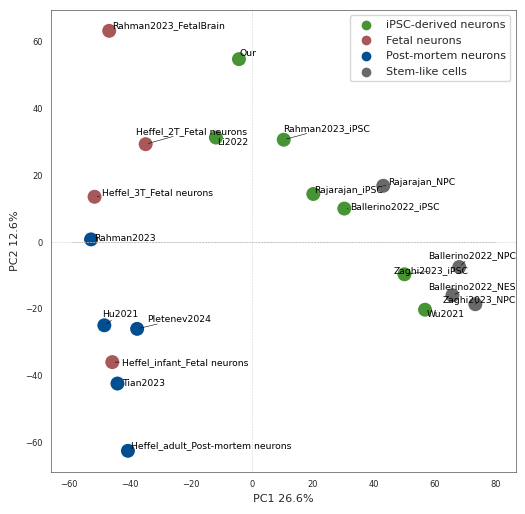

               In some cases adjust_text might fail, if possible update
               matplotlib to version >=3.5.0


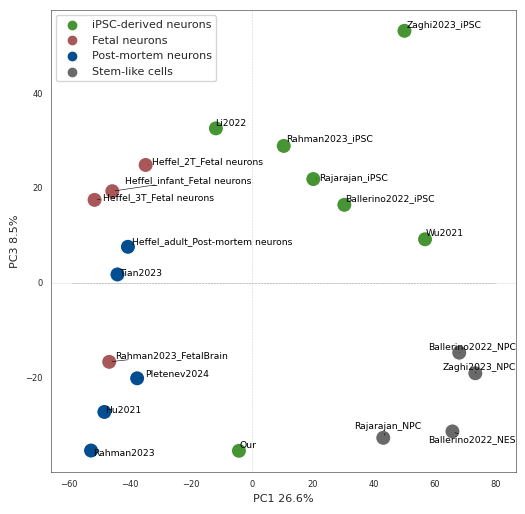

               In some cases adjust_text might fail, if possible update
               matplotlib to version >=3.5.0


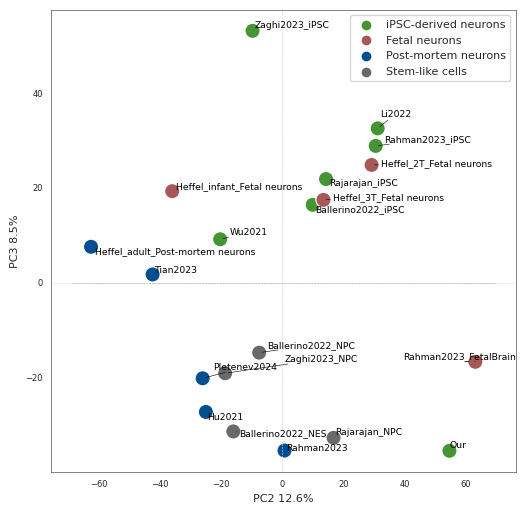

In [128]:
for pca_sel in [['PC1','PC2'], ['PC1','PC3'],['PC2','PC3']]:
    plot_pca(pca, components_df, pca_sel, path_to_save_visualizations, use_min_max=False, min_v=-550, max_v = 790, save_name=None)

## 3. Clustered TADs border by groups

In [242]:
def get_selected_group_clusters(selected_groups, insulation_score_datasets, path_to_tads = path_to_tads, samples2groups = samples2groups, remove_heffel_infant=False):
    counter_filtered = {i: k for i, k in counter.items() if i in selected_groups}
    samples2groups_filtered = {
        i: k for i, k in samples2groups.items()
        if k in selected_groups and "Lu2020" not in i
    }

    if remove_heffel_infant:
        samples2groups_filtered = {
            i: k for i, k in samples2groups_filtered.items() if "infant" not in i
        }

    validator_df = pd.DataFrame([samples2groups_filtered]).T.groupby(0).size()
    for i in validator_df.index.unique():
        if not remove_heffel_infant:
            assert validator_df[i] == counter_filtered[i]

    ordered_counter_filtered = {item: counter_filtered[item] for item in selected_groups}
    selected_groups_name = f"{selected_groups[0]}_vs_{selected_groups[1]}"

    all_files = []
    for selected_group in selected_groups:
        filtered_samples2groups = {i: k for i, k in samples2groups.items() if k == selected_group}
        filtered_samples_keys = filtered_samples2groups.keys()
        
        selected_insulation_score_datasets = [
            i for i in insulation_score_datasets if any(k in i for k in filtered_samples_keys) and "Lu2020" not in i
        ]
        
        if selected_group in ['Post-mortem neurons', 'Fetal neurons']:
            selected_insulation_score_datasets = [i for i in selected_insulation_score_datasets if "iPSC" not in i]
        
        if remove_heffel_infant:
            selected_insulation_score_datasets = [i for i in selected_insulation_score_datasets if "infant" not in i]
            
        if not remove_heffel_infant:
            assert len(selected_insulation_score_datasets) == counter[selected_group]

        all_files.extend(selected_insulation_score_datasets)

    all_files  = [os.path.join(path_to_tads, f) for f in all_files]
    all_files.sort()
    bed = create_merged_bed(all_files, samples2groups)

    df_res_final_cluster_sel_groups, merged_bed_sel_group = merge_bed(
        bed, res=15000, cluster_factor=min(ordered_counter_filtered.values()) - 2,
        dist_method='cityblock', min_pts=3
    )

    if not remove_heffel_infant:
        assert (
            len(all_files) == 
            sum(counter[i] for i in selected_groups) == 
            bed.source.nunique() ==
            df_res_final_cluster_sel_groups.source.nunique()
        )

    comparisons_sel_group, all_clusters_sel_group, _ = analyze_clusters(
        merged_bed_sel_group, make_stats=True, dict_counter=ordered_counter_filtered,
        dict_sample_to_group=samples2groups_filtered, feature_column='cluster',
        remove_heffel_infant=remove_heffel_infant
    )

    merged_bed_sel_group = merged_bed_sel_group.merge(comparisons_sel_group, on="cluster")
    merged_bed_sel_group.dropna(inplace=True)

    first_key = next(iter(all_clusters_sel_group))
    if not remove_heffel_infant:
        assert (
            len(all_files) == 
            len(all_clusters_sel_group[first_key]) == 
            merged_bed_sel_group.source.nunique()
        )

    return selected_groups_name, merged_bed_sel_group, all_clusters_sel_group, comparisons_sel_group

def save_data_for_pca(all_clusters_data, components_df, selected_groups_name, path_to_save_pca_data):
    data_for_pca = all_clusters_data.T
    data_for_pca['source'] = list(components_df['sample_simple'] + "_" + components_df["group"])

    data_for_pca = data_for_pca.reset_index(drop=True)
    data_for_pca.index.name = None
    assert len(set(data_for_pca.source)) > 1

    data_for_pca.to_csv(f'{path_to_save_pca_data}/{selected_groups_name}_tads_clusters.tsv', index=False, sep='\t')
    
    return data_for_pca

In [243]:
def process_comparisons(comparisons, insulation_score_datasets):
    comparisons_div = [comp.split("_vs_") for comp in comparisons]
    all_merged_pairs = {}

    for left, right in comparisons_div:
        print(f"Processing: {left} vs {right}")
        selected_groups_name, merged_bed_sel_group, all_clusters_sel_group, comparisons_sel_group = \
            get_selected_group_clusters([left, right], insulation_score_datasets)

        cluster_filter = lambda x: "_-1" not in x
        all_clusters_sel_group = {k: v for k, v in all_clusters_sel_group.items() if cluster_filter(k)}
        comparisons_sel_group = comparisons_sel_group[comparisons_sel_group.cluster.map(cluster_filter)]
        merged_bed_sel_group = merged_bed_sel_group[merged_bed_sel_group.cluster.map(cluster_filter)]

        all_merged_pairs[selected_groups_name] = {
            'merged_df': merged_bed_sel_group,
            'all_clusters': all_clusters_sel_group,
            'comparisons': comparisons_sel_group
        }

        assert (merged_bed_sel_group.end - merged_bed_sel_group.start).eq(15000).all()

        print(f"Number of clusters - {merged_bed_sel_group.cluster.nunique()}")
        print('__' * 13)

    return all_merged_pairs

def apply_fdr_correction(all_merged_pairs):
    col_name = "cluster"
    stat_col = "p_value"

    for selected_groups_name, data in all_merged_pairs.items():
        print(f"Applying FDR correction for {selected_groups_name}")
        merged_bed_sel_group, comparisons_sel_group = data['merged_df'], data['comparisons']
        
        _, fdr_corrected = fdrcorrection(comparisons_sel_group[f"{selected_groups_name}_{stat_col}"])
        q_value_col_name = f'{selected_groups_name}_q-value_{stat_col}'
        comparisons_sel_group[q_value_col_name] = fdr_corrected

        correction_mapping = dict(zip(comparisons_sel_group[col_name], fdr_corrected))
        merged_bed_sel_group[q_value_col_name] = merged_bed_sel_group[col_name].map(correction_mapping)

        all_merged_pairs[selected_groups_name].update({
            'merged_df': merged_bed_sel_group,
            'comparisons': comparisons_sel_group
        })
        

def save_processed_data(all_merged_pairs, comparisons_div, output_dir):
    os.makedirs(output_dir, exist_ok=True)
    # mapping_short_names = {row['source']: row['short_name_for_plot'] for _, row in SHORT_NAME_FOR_PLOT.iterrows()}
    mapping["short_name_for_plot"] = mapping['sample'].map(SHORT_NAME_FOR_PLOT)
    # short_name_mapping["short_name_for_plot"] = short_name_mapping['sample'].map(SHORT_NAME_FOR_PLOT)

    for left, right in comparisons_div:
        selected_groups_name = f"{left}_vs_{right}"
        merged_df = all_merged_pairs[selected_groups_name]['merged_df']
        # check_merge_effects(all_merged_pairs[selected_groups_name]['merged_df'])
        merged_df = merged_df.merge(mapping[['source', 'short_name_for_plot', 'Group', 'Simple_Name']], on='source')

        merged_df.to_pickle(os.path.join(output_dir, f'{selected_groups_name}_clusters_merged_df.pickle'))
        all_merged_pairs[selected_groups_name]['comparisons'].to_pickle(
            os.path.join(output_dir, f'{selected_groups_name}_clusters_comparisons.pickle')
        )

In [ ]:
comparisons = ['Post-mortem neurons_vs_Fetal neurons',
 'Post-mortem neurons_vs_iPSC-derived neurons',
'Post-mortem neurons_vs_Stem-like cells',
 'Fetal neurons_vs_iPSC-derived neurons',
'Fetal neurons_vs_Stem-like cells',
'iPSC-derived neurons_vs_Stem-like cells']

SHORT_NAME_FOR_PLOT = {'Ballerino2022_NES_Stem cells': 'NES Ballerino',
 'Ballerino2022_NPC_Stem cells': 'NPC Ballerino',
 'Ballerino2022_iPSC_NeuNplus_iPSC-derived': 'Ballerino',
 'Heffel_2T_Developing': 'Heffel (2T)',
 'Heffel_3T_Developing': 'Heffel (3T)',
 'Heffel_adult_Post-mortem': 'Heffel',
 'Heffel_infant_Developing': 'Heffel (infant)',
 'Hu2021_NeuNplus_Post-mortem': 'Hu',
 'Our_data_iPSC_NeuNplus': 'Our data\n(iPSC-derived\nneurons)',
 'Li2022_iPSC_NeuNplus_iPSC-derived': 'Li',
 'Pletenev2024_NeuNplus_Post-mortem': 'Our data\n(Post-mortem\nneurons)',
 'Rajarajan_iPSC_NeuNplus_iPSC-derived': 'Rajarajan',
 'Rahman2023_FetalBrain_Developing': 'Rahman\n(Fetal\nneurons)',
 'Rahman2023_NeuNplus_Post-mortem': 'Rahman\n(Post-mortem\nneurons)',
 'Rahman2023_iPSC_NeuNplus_iPSC-derived': 'Rahman\n(iPSC-derived\nneurons)',
 'Rajarajan_NPC_5kb_Stem cells': 'NPC Rajarajan',
 'Tian2023_NeuNplus_Post-mortem': 'Tian',
 'Wu2021_iPSC_NeuNplus_iPSC-derived': 'Wu',
 'Zaghi2023_NPC_5kb_Stem cells': 'NPC Zaghi',
 'Zaghi2023_iPSC_NeuNplus_iPSC-derived': 'Zaghi'}

In [202]:
all_merged_pairs = process_comparisons(comparisons, insulation_score_datasets)
apply_fdr_correction(all_merged_pairs)
save_processed_data(all_merged_pairs, comparisons_div, path_to_tads_clusters)


## 4. PCA on clustered TADs by groups

In [211]:
def perform_pca_analysis_for_comparisons(comparisons_div, comparisons, all_merged_pairs, samples2groups, path_to_save_visualizations=path_to_save_visualizations, path_to_save_pca_data=path_to_save_pca_data):
    """
    Performs PCA analysis on provided data and handles exceptions.

    Args:
        comparisons_div (list of tuples): Groups to compare.
        comparisons (list): Names for the comparisons.
        all_merged_pairs (dict): Collection of data for each group comparison.
        samples2groups (dict): Mapping of samples to groups.

    Returns:
        dict: Contains processed PCA data for all comparisons.
    """
    data_for_pca_all = {}

    for selected_groups, name in zip(comparisons_div, comparisons):
        try:
            selected_groups_name = f"{selected_groups[0]}_vs_{selected_groups[1]}"
            print(f"Processing: {selected_groups_name}")
            all_clusters_data = all_merged_pairs[selected_groups_name]['all_clusters']
            renamed_clusters_data = rename_all_clusters_data(all_clusters_data, samples2groups)

            components_df, pca = make_pca_on_df(
                renamed_clusters_data,
                path_to_save_pca_data,
                save_name = f"tadBorders_PCA_15res_150wind_clusters_{selected_groups_name}",
                remove_coordinates=False
            )
            
            print(f"Explained Variance Ratio: {pca.explained_variance_ratio_}")

            data_for_pca = save_data_for_pca(renamed_clusters_data, components_df, selected_groups_name, path_to_save_pca_data)
            data_for_pca_all[selected_groups_name] = data_for_pca

            for pca_sel in [['PC1', 'PC2'], ['PC1', 'PC3'], ['PC2', 'PC3']]:
                plot_pca(
                    pca, components_df, pca_sel,
                    use_min_max=False, min_v=-550, max_v=790, save_name=None, path_to_save_visualizations=path_to_save_visualizations
                )
        
            print('__' * 13)
        
        except KeyError as e:
            print(f"Key error: {e} not found in all_merged_pairs or related data structures.")
        except Exception as e:
            print(f"An unexpected error occurred: {e}")

    return data_for_pca_all

Processing: Post-mortem neurons_vs_Fetal neurons
Explained Variance Ratio: [0.3174483  0.21455896 0.11563444 0.08967538 0.07505398 0.06636915]


               In some cases adjust_text might fail, if possible update
               matplotlib to version >=3.5.0


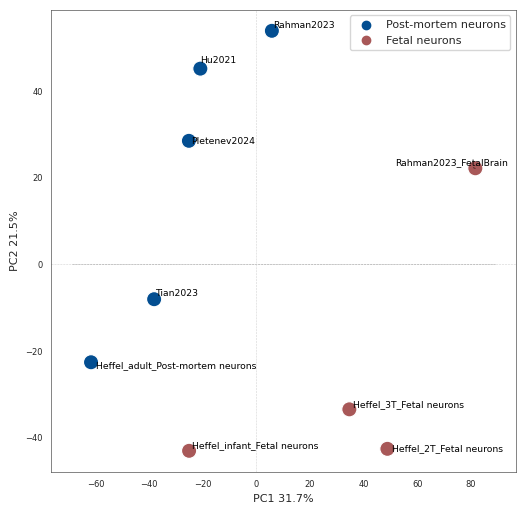

               In some cases adjust_text might fail, if possible update
               matplotlib to version >=3.5.0


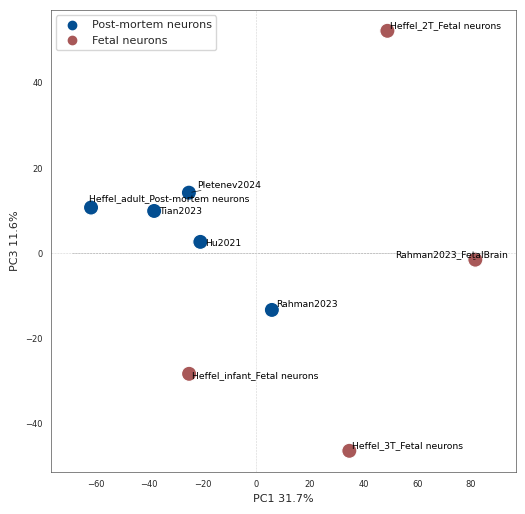

               In some cases adjust_text might fail, if possible update
               matplotlib to version >=3.5.0


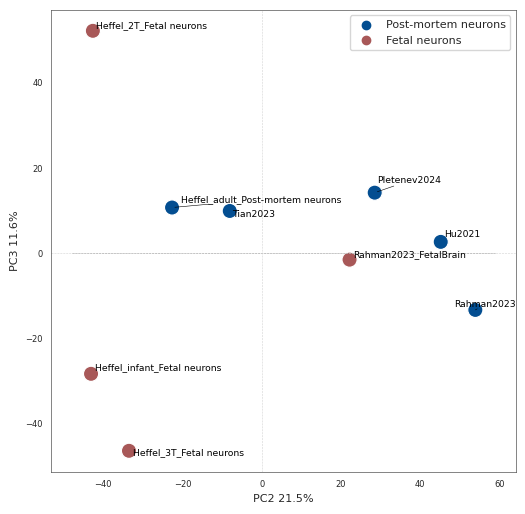

__________________________
Processing: Post-mortem neurons_vs_iPSC-derived neurons


               In some cases adjust_text might fail, if possible update
               matplotlib to version >=3.5.0


Explained Variance Ratio: [0.30358037 0.16275654 0.10790113 0.07901078 0.0736732  0.05925807]


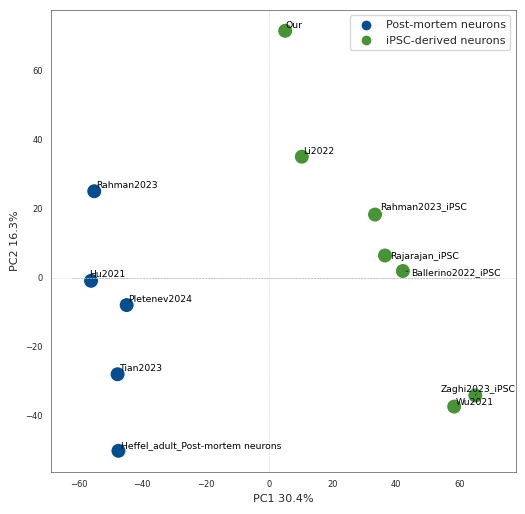

               In some cases adjust_text might fail, if possible update
               matplotlib to version >=3.5.0


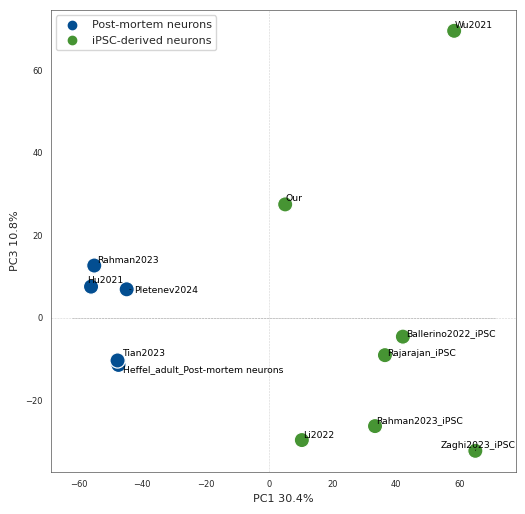

               In some cases adjust_text might fail, if possible update
               matplotlib to version >=3.5.0


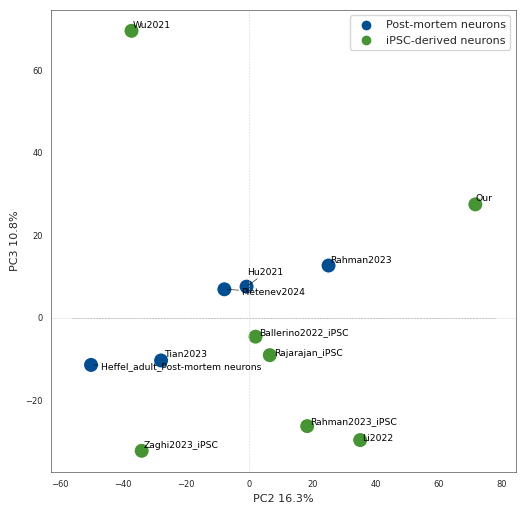

__________________________
Processing: Post-mortem neurons_vs_Stem-like cells
Explained Variance Ratio: [0.46656902 0.13494645 0.10171573 0.07969183 0.06919619 0.05285844]


               In some cases adjust_text might fail, if possible update
               matplotlib to version >=3.5.0


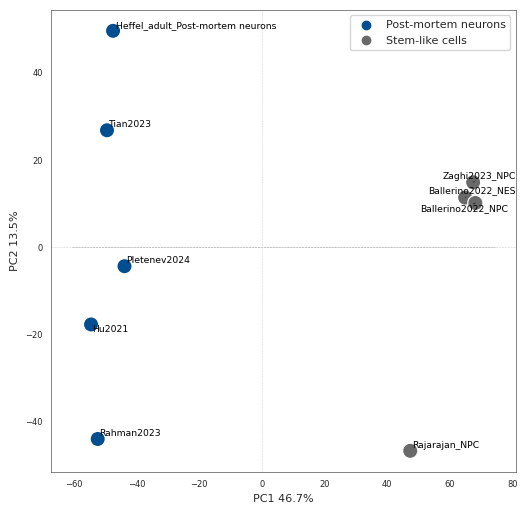

               In some cases adjust_text might fail, if possible update
               matplotlib to version >=3.5.0


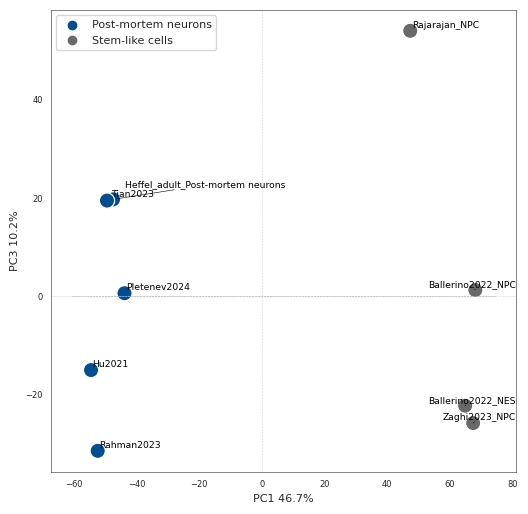

               In some cases adjust_text might fail, if possible update
               matplotlib to version >=3.5.0


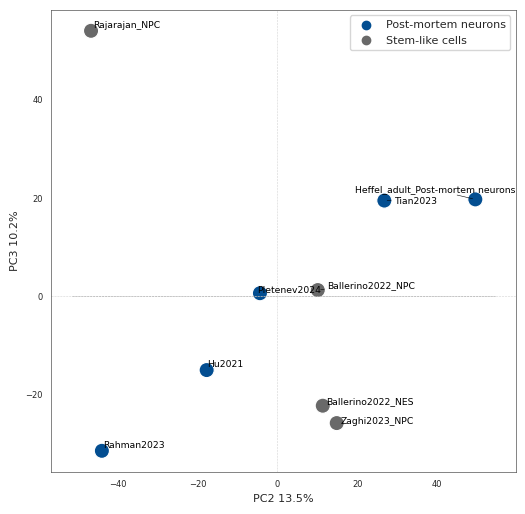

__________________________
Processing: Fetal neurons_vs_iPSC-derived neurons
Explained Variance Ratio: [0.29814253 0.15310822 0.11016218 0.08121094 0.07980898 0.07747258]


               In some cases adjust_text might fail, if possible update
               matplotlib to version >=3.5.0


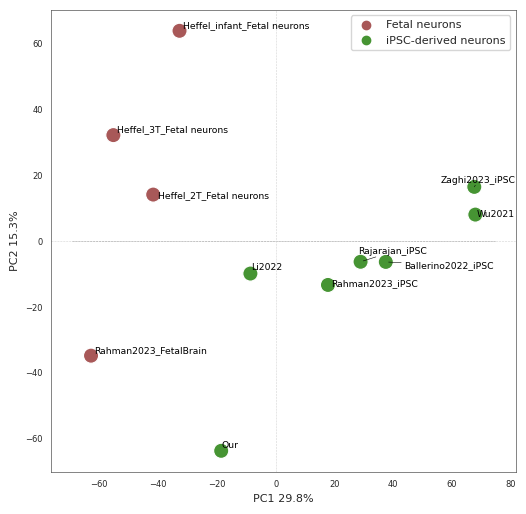

               In some cases adjust_text might fail, if possible update
               matplotlib to version >=3.5.0


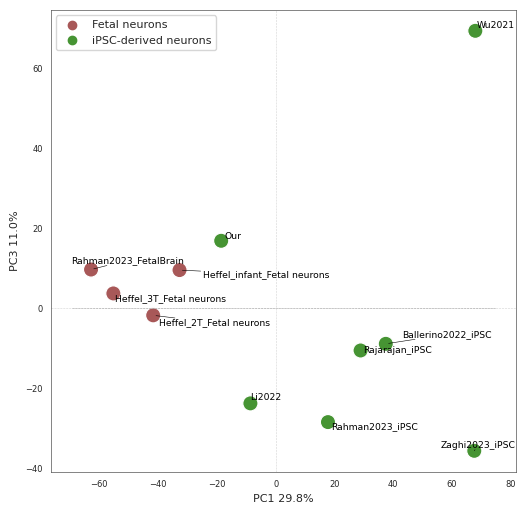

               In some cases adjust_text might fail, if possible update
               matplotlib to version >=3.5.0


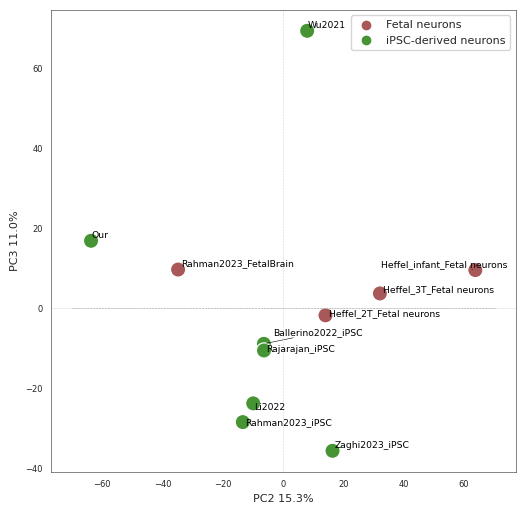

__________________________
Processing: Fetal neurons_vs_Stem-like cells
Explained Variance Ratio: [0.46865291 0.15468306 0.09886834 0.09266825 0.0763951  0.05860154]


               In some cases adjust_text might fail, if possible update
               matplotlib to version >=3.5.0


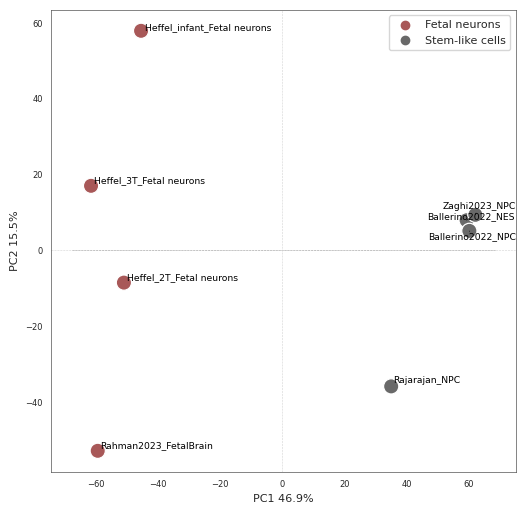

               In some cases adjust_text might fail, if possible update
               matplotlib to version >=3.5.0


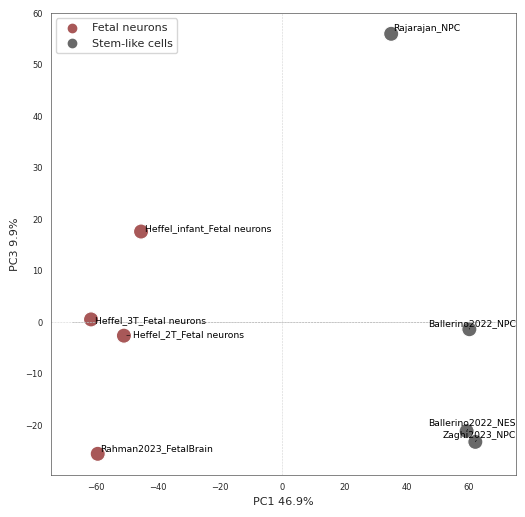

               In some cases adjust_text might fail, if possible update
               matplotlib to version >=3.5.0


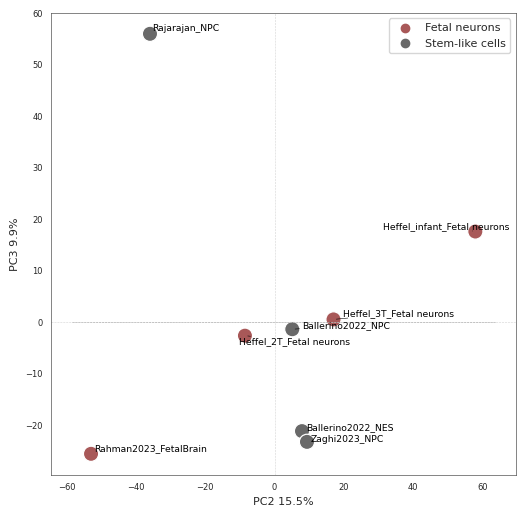

__________________________
Processing: iPSC-derived neurons_vs_Stem-like cells


               In some cases adjust_text might fail, if possible update
               matplotlib to version >=3.5.0


Explained Variance Ratio: [0.26664471 0.15871508 0.11426943 0.09862489 0.09006769 0.07843004]


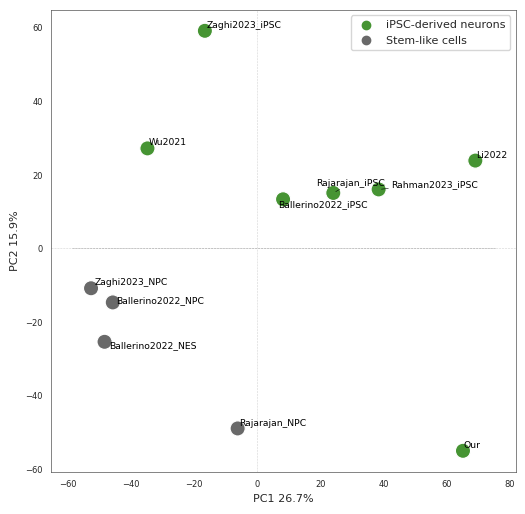

               In some cases adjust_text might fail, if possible update
               matplotlib to version >=3.5.0


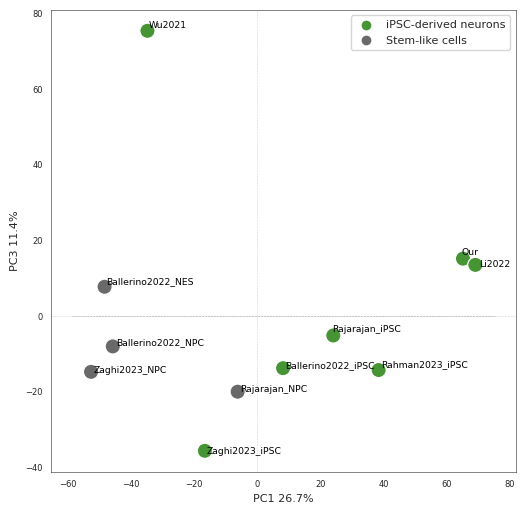

               In some cases adjust_text might fail, if possible update
               matplotlib to version >=3.5.0


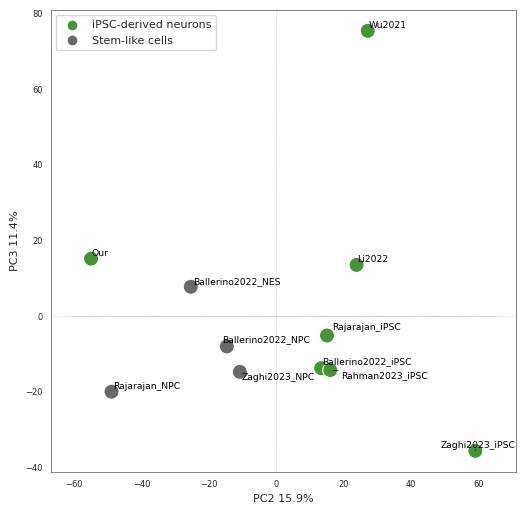

__________________________


In [245]:
data_for_pca_all = perform_pca_analysis_for_comparisons(comparisons_div, comparisons, all_merged_pairs, samples2groups)